### A Song of Vice and Higher: Characterizing Presidential Nominees through Game of Thrones

---

## To Dos
- 'Doran'
- Fix comment length metric
- Explore more gensim features?
- Plotting similarity scores
- Manually use clusters | similarity scores to match GoT to Dems?


## Table of Contents

**<a href=#get_data>Get Data</a>**

**<a href=#attribution>Comment Attribution</a>**

**<a href=#person_sentiment>Sentiment by Person</a>**

**<a href=#clusters>Cluster Analysis</a>**

**<a href=#embeddings>Word Embeddings</a>**

**<a href=#clusters2>Cluster Analysis, Revisited</a>**


### Import Necessary Libraries

In [254]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
%reload_ext autoreload

In [256]:
import os             # file system stuff
import json           # digest json
import pandas as pd   # Dataframes
import numpy as np    # arrays and matrix ops
import string         # string manipulation

import psycopg2 as psql # PostgreSQL
from itertools import chain # Chain

# Plotting
import matplotlib.pyplot as plt
import plotly_express as px

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import gensim         # Word embeddings

# Custom Libs
import helper     # Custom helper functions
from helper import attribute_comment 
from helper import create_person_mat
from helper import add_similarity_score
from helper import person_dict
from helper import domain_dict


### Connect to the database <a name="get_data"/>

In [257]:
# Define path to secret

# secret_path_aws = os.path.join(os.environ['HOME'], 'mia', '.secret', 
#                            'aws_ps_flatiron.json')
secret_path_aws = os.path.join(os.environ['HOME'], '.secret', 
                           'aws_ps_flatiron.json')
secret_path_aws

'/Users/werlindo/.secret/aws_ps_flatiron.json'

In [258]:
aws_keys = helper.get_keys(secret_path_aws)
user = aws_keys['user']
ps = aws_keys['password']
host = aws_keys['host']
db = aws_keys['db_name']

aws_ps_engine = ('postgresql://' + user + ':' + ps + '@' + host + '/' + db)

# Setup PSQL connection
conn = psql.connect(
    database=db,
    user=user,
    password=ps,
    host=host,
    port='5432'
)

In [259]:
get_database = """
    SELECT * FROM comms_sntmnt_190614;
"""
# Instantiate cursor
cur = conn.cursor()
cur.execute(get_database)
comments = pd.DataFrame(cur.fetchall())
comments.columns = [col.name for col in cur.description]
comments.drop('index', axis=1, inplace=True) #superfluous column
comments.drop(['compound', 'neu'], axis=1, inplace=True) 
#compound and neutral are correlated with other sentiment columns

In [260]:
comments.head()

,domain,comment,sub_num_comments,sub_upvote_ratio,neg,pos
0,dems,"2016, when the dnc pulled the same bullshit th...",710,0.97,0.236,0.069
1,dems,2016: who the hell is beto?\n\n2019: how could...,759,0.96,0.228,0.175
2,dems,>2017 house approval of a $700 billion defense...,105,0.43,0.088,0.383
3,dems,2018,850,0.93,0.000,0.000
4,dems,2018?,508,0.96,0.000,0.000


## Attribute Comment to Person <a name='attribution' />

In order to attribute people to `comment`s, we can perform count vectorization. We will need to create a vocabulary.

In [261]:
# Vocabulary will be list of all the search terms we used 
# to pull reddit submissions
vocab = list(chain(*helper.person_dict.values()))

vocab[:10]

['bran',
 'brandon stark',
 'jon',
 'jon snow',
 'khaleesi',
 'dany',
 'daenerys',
 'danyris',
 'danny',
 'danaerys']

Next, set up vectorizer, and then vectorize on this `vocab`

In [262]:
vectorizer = CountVectorizer(vocabulary=vocab)

vectorized_words = vectorizer.transform(comments['comment'])

In [263]:
vectorized_words.shape

(324629, 114)

This gets us an $axn$ matrix, where:
- $a$ is the number of _comments_
- $n$ is the number of _vocab words (search terms)_.

Let's take a look at the vectorized words. Here's one row.

In [264]:
vectorized_words.todense()[5, :]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]])

The columns show the count of vocab word in the comment (row).

In [265]:
# Check
vectorizer.vocabulary[:10]

['bran',
 'brandon stark',
 'jon',
 'jon snow',
 'khaleesi',
 'dany',
 'daenerys',
 'danyris',
 'danny',
 'danaerys']

Now we want to set up a $nxm$ matrix, where:
- $n$ will be number of search terms (e.g. 'dany', daenerys' for **daenerys**) 
- $m$ is the actual number of persons (e.g. **daenerys** herself). 

Let's start with a matrix of `0`s.

In [266]:
person_mat = np.zeros((len(person_dict), len(vocab))).T

person_mat.shape

(114, 67)

Now, let's assign column IDs in the matrix for each _person_.

In [267]:
person_ids = {}

for i, name in enumerate(person_dict.keys()):
    person_ids[name] = i
    
person_ids               

{'bran': 0,
 'jon': 1,
 'dany': 2,
 'davos': 3,
 'doran': 4,
 'cersei': 5,
 'tyrion': 6,
 'sansa': 7,
 'arya': 8,
 'stannis': 9,
 'varys': 10,
 'jamie': 11,
 'brienne': 12,
 'samwell': 13,
 'jorah': 14,
 'theon': 15,
 'hound': 16,
 'littlefinger': 17,
 'joffrey': 18,
 'mountain': 19,
 'robb': 20,
 'dragons': 21,
 'melisandre': 22,
 'bronn': 23,
 'gilly': 24,
 'ramsey': 25,
 'missandei': 26,
 'gendry': 27,
 'grey worm': 28,
 'ned': 29,
 'catelyn': 30,
 'tormund': 31,
 'robert': 32,
 'tommen': 33,
 'viserys': 34,
 'margaery': 35,
 'euron': 36,
 'oberyn': 37,
 'night_king': 38,
 'lyanna': 39,
 'jaqen': 40,
 'hodor': 41,
 'ygritte': 42,
 'mance': 43,
 'harris': 44,
 'biden': 45,
 'buttigieg': 46,
 'gillibrand': 47,
 'hickenlooper': 48,
 'klobuchar': 49,
 'warren': 50,
 'booker': 51,
 'inslee': 52,
 'castro': 53,
 'gabbard': 54,
 'sanders': 55,
 'de blasio': 56,
 'bullock': 57,
 'gravel': 58,
 'messam': 59,
 "o'rourke": 60,
 'bennet': 61,
 'delaney': 62,
 'moulton': 63,
 'swalwell': 64,
 'w

...and assign row ids for each _search term_.

In [268]:
vocab_ids = {}

for i, word in enumerate(vocab):
    vocab_ids[word] = i
    
vocab_ids                

{'bran': 0,
 'brandon stark': 1,
 'jon': 2,
 'jon snow': 3,
 'khaleesi': 4,
 'dany': 5,
 'daenerys': 6,
 'danyris': 7,
 'danny': 8,
 'danaerys': 9,
 'daenarys': 10,
 'davos': 11,
 'doran': 12,
 'cersei': 13,
 'cercei': 14,
 'tyrion': 15,
 'tirion': 16,
 'sansa': 17,
 'arya': 18,
 'stannis': 19,
 'varys': 20,
 'varis': 21,
 'jamie': 22,
 'jaime': 23,
 'brienne': 24,
 'brianne': 25,
 'samwell': 26,
 'jorah': 27,
 'theon': 28,
 'hound': 29,
 'sandor': 30,
 'littlefinger': 31,
 'baelish': 32,
 'joffrey': 33,
 'joff': 34,
 'mountain': 35,
 'gregor': 36,
 'robb': 37,
 'drogo': 38,
 'melisandre': 39,
 'bronn': 40,
 'gilly': 41,
 'ramsey': 42,
 'ramsay': 43,
 'missandei': 44,
 'gendry': 45,
 'grey worm': 46,
 'greyworm': 47,
 'gray worm': 48,
 'grayworm': 49,
 'ned': 50,
 'eddard': 51,
 'catelyn': 52,
 'torumund': 53,
 'tormund': 54,
 'giantsbane': 55,
 'robert': 56,
 'tommen': 57,
 'viserys': 58,
 'margaery': 59,
 'euron': 60,
 'oberon': 61,
 'oberyn': 62,
 'viper': 63,
 'red viper': 64,
 'ni

Now let's use `person_dict` to fill a 1 where each _search term_ matches it's _person_. 

In [269]:
for name, words in person_dict.items():
    person_id = person_ids[name]
    for word in words:
        vocab_id = vocab_ids[word]
        person_mat[vocab_id, person_id] = 1 

In [270]:
person_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Now we can use matrix multplication to get an $axm$ matrix where:
- $a$: number of _comments_
- $m$: number of _persons_

In [271]:
mentions = vectorized_words @ person_mat 

mentions.shape

(324629, 67)

In [272]:
mentions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Get list of _persons_.

In [273]:
persons = list(person_dict.keys())

Create a dataframe from the matrix, with _persons_ as column headers.

In [274]:
mentions_df = pd.DataFrame(mentions, columns=persons, index=comments.index) 

mentions_df.head()

,bran,jon,dany,davos,doran,cersei,tyrion,sansa,arya,stannis,...,bullock,gravel,messam,o'rourke,bennet,delaney,moulton,swalwell,williamson,yang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create a `comment_length` feature. We think we will use this as some sort of weighting metric, i.e. the longer the comment, the more weight it carries....?

In [275]:
comments['comment_length'] = comments['comment'].str.len()

comments.head()

,domain,comment,sub_num_comments,sub_upvote_ratio,neg,pos,comment_length
0,dems,"2016, when the dnc pulled the same bullshit th...",710,0.97,0.236,0.069,276
1,dems,2016: who the hell is beto?\n\n2019: how could...,759,0.96,0.228,0.175,80
2,dems,>2017 house approval of a $700 billion defense...,105,0.43,0.088,0.383,170
3,dems,2018,850,0.93,0.000,0.000,4
4,dems,2018?,508,0.96,0.000,0.000,5


The `comment`s have served their purpose, so we can drop them. 

In [276]:
com_use = comments.drop(['comment'],axis=1).copy()

com_use.head()

,domain,sub_num_comments,sub_upvote_ratio,neg,pos,comment_length
0,dems,710,0.97,0.236,0.069,276
1,dems,759,0.96,0.228,0.175,80
2,dems,105,0.43,0.088,0.383,170
3,dems,850,0.93,0.000,0.000,4
4,dems,508,0.96,0.000,0.000,5


Create a master table that has the sentiment analysis **and** the mentions counts.

In [277]:
snm = com_use.join(mentions_df)

snm.head()

,domain,sub_num_comments,sub_upvote_ratio,neg,pos,comment_length,bran,jon,dany,davos,...,bullock,gravel,messam,o'rourke,bennet,delaney,moulton,swalwell,williamson,yang
0,dems,710,0.97,0.236,0.069,276,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dems,759,0.96,0.228,0.175,80,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dems,105,0.43,0.088,0.383,170,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dems,850,0.93,0.000,0.000,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dems,508,0.96,0.000,0.000,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


_**Version of table with `comment` column preserved**_


In [278]:
comm_snm = comments.join(mentions_df)

comm_snm.head()

,domain,comment,sub_num_comments,sub_upvote_ratio,neg,pos,comment_length,bran,jon,dany,...,bullock,gravel,messam,o'rourke,bennet,delaney,moulton,swalwell,williamson,yang
0,dems,"2016, when the dnc pulled the same bullshit th...",710,0.97,0.236,0.069,276,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dems,2016: who the hell is beto?\n\n2019: how could...,759,0.96,0.228,0.175,80,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dems,>2017 house approval of a $700 billion defense...,105,0.43,0.088,0.383,170,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dems,2018,850,0.93,0.000,0.000,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dems,2018?,508,0.96,0.000,0.000,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

### <font color='red'> Digression: Saving out dataframe to-date as a tab-delimited file.

<font color='red'> 2019.06.15 - I commented out these cells; might want to keep them for a couple more days, but don't want to have to keep manually skipping.

**<a href=#bookmark>Click here to skip this section</a>**

#### Write out to tsv

comm_snm.to_csv('comm_snm_190614.tsv', sep='\t')

##### Test reading back in

csnm_test = pd.read_csv('comm_snm_190614.tsv', sep='\t')

csnm_test.info()

csnm_test.head()

csnm_test.shape

comm_snm.shape

We _gained_ a few rows? and a weird index column. Immaterial for now, for think is easily fixable.

Check file size.

file_path_nm = "comm_snm_190614.tsv"
filesize = os.path.getsize(file_path_nm)/1000000

print("file_path_nm is roughly {:,.0f}MB.".format(filesize))

### <font color='red'>End Digression.<a name='bookmark' /></font>

---

## Get aggregate sentiment <a name="person_sentiment" />

We want a table that has `person` on the row, and a column for each `sentiment` metric. We can use matrix multiplication again to achieve that.

In [279]:
mentions.shape

(324629, 67)

In [280]:
# Transpose the mentions matrix
men_t = mentions.T


In [281]:
men_t.shape

(67, 324629)

Isolate just the metrics columns.

In [282]:
# Get the positive sentiment column as an array
features = np.array(snm[['pos','neg','comment_length']])

In [283]:
features.shape

(324629, 3)

Compute target matrix of aggregated sentiment.

In [284]:
snm_agg = men_t @ features 

In [285]:
snm_agg.shape

(67, 3)

This gives us a matrix of rows of **persons** by [ **neg**, **pos**, **comment length** ]. But recall this is matrix multiplication, so it gives us the sumproduct. So we need to take the weighted average.

Create an $mx1$ matrix that represents a column of total comment 'hits' for each `person`.

In [286]:
# Get total comments 'hits' by person
men_t_agg = men_t.sum(axis=1)

In [287]:
men_t_agg.shape

(67,)

In [288]:
num_persons = len(persons)

In [289]:
# We need this as an nx1 array
men_t_agg = np.reshape(men_t_agg,(num_persons,1))

In [290]:
men_t_agg.shape

(67, 1)

Now divide the original matrix by 'hits' to get average 'scores'.

In [291]:
snm_avg = np.divide(snm_agg, men_t_agg)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [292]:
snm_avg[0]

array([9.58706816e-02, 9.64069795e-02, 8.31949230e+02])

This looks right. Now make `persons_df`

In [293]:
persons_df = pd.DataFrame(snm_avg, columns=['neg','pos','comment_length'])

In [294]:
# Add the person's name back in
persons_df['person'] = persons

In [295]:
# Add domain back in
persons_df['domain'] = persons_df['person'].map(domain_dict)

In [296]:
persons_df = persons_df[['person', 'domain', 'neg', 'pos', 'comment_length']]

In [297]:
persons_df.shape

(67, 5)

In [298]:
persons_df.tail(30)

,person,domain,neg,pos,comment_length
37,oberyn,got,0.118462,0.124522,534.238994
38,night_king,got,0.096079,0.121316,371.236842
39,lyanna,got,NaN,NaN,NaN
40,jaqen,got,0.081677,0.087890,668.445122
41,hodor,got,0.058301,0.060560,917.197970
42,ygritte,got,0.131634,0.102654,500.151220
43,mance,got,0.095994,0.117767,493.245283
44,harris,dems,0.121952,0.073905,601.044709
45,biden,dems,0.112405,0.086870,550.885796
46,buttigieg,dems,0.121666,0.065769,646.673913


In [299]:
persons_df.sort_values(by=['comment_length'], axis=0, ascending=False)

,person,domain,neg,pos,comment_length
54,gabbard,dems,0.107591,0.092146,1330.751905
36,euron,got,0.097175,0.139224,958.506540
41,hodor,got,0.058301,0.060560,917.197970
20,robb,got,0.098480,0.131667,902.553476
12,brienne,got,0.117134,0.113103,898.926866
26,missandei,got,0.105467,0.144538,891.237405
2,dany,got,0.101242,0.136775,887.895739
5,cersei,got,0.104796,0.141244,865.036902
21,dragons,got,0.103937,0.132336,863.264463
7,sansa,got,0.106343,0.116680,836.954370


<s>That's it! We will deal with NA's as situations come up.</s>  
Let's get rid of nulls.

In [300]:
persons_df = persons_df.dropna(axis=0)

In [301]:
persons_df.shape

(66, 5)

---

## Cluster Analysis <a name='clusters'/>

### Data Setup

In [302]:
# Create a person-indexed df
persons_cluster = persons_df.set_index(['person']).drop(['domain'], axis=1)

In [303]:
persons_cluster.tail()

,neg,pos,comment_length
person,,,
delaney,0.100648,0.073381,592.190476
moulton,0.121841,0.063362,419.956522
swalwell,0.133085,0.066930,554.845070
williamson,0.085211,0.072123,443.578947
yang,0.127172,0.059265,641.174575


In [304]:
persons_cluster.shape

(66, 3)

Drop any nulls.

In [305]:
persons_cluster = persons_cluster.dropna(axis=0)

persons_cluster.shape

(66, 3)

In [306]:
persons_cluster.head()

,neg,pos,comment_length
person,,,
bran,0.095871,0.096407,831.949230
jon,0.105712,0.123610,797.009912
dany,0.101242,0.136775,887.895739
davos,0.124050,0.092575,692.760499
doran,0.086200,0.117733,532.200000


Scale the data.

In [307]:
persons_cluster.dropna(axis=0).shape

(66, 3)

In [308]:
ss = StandardScaler()

ss.fit(persons_cluster)

scaled_X = ss.transform(persons_cluster.dropna(axis=0))

scaled_df = pd.DataFrame(scaled_X, columns=persons_cluster.columns
                         , index=persons_cluster.index)

scaled_df.head()

,neg,pos,comment_length
person,,,
bran,-0.916536,-0.149890,0.948253
jon,-0.215131,0.776966,0.746595
dany,-0.533699,1.225546,1.271157
davos,1.091774,-0.280437,0.144904
doran,-1.605757,0.576743,-0.781796


### Find optimal K

**Elbow Method**

In [309]:
# Elbow Method
cluster_variation = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    cluster_variation.append(kmeans.inertia_)

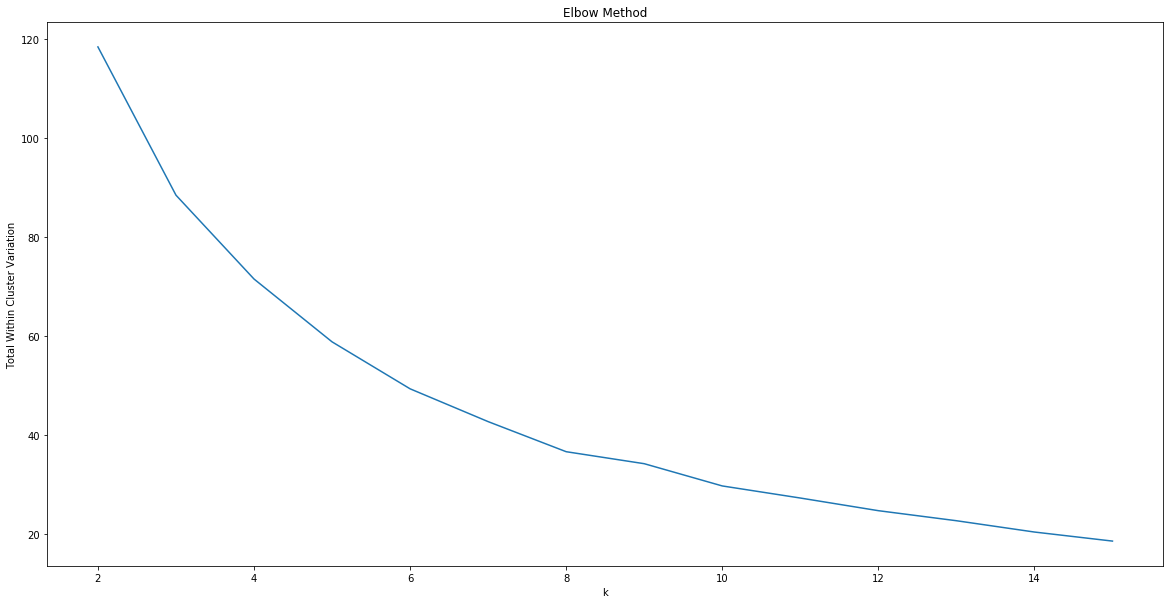

In [310]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Total Within Cluster Variation')
plt.title('Elbow Method')
plt.plot(range(2,16), cluster_variation)


Interesting. Right now we would say k = 4.

### Silhouette Method

In [311]:
silhouette_score = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_df)
    labels = kmeans.labels_
    
    score = metrics.silhouette_score(scaled_df, labels, metric='euclidean')
    silhouette_score.append(score)

In [312]:
#Check 
silhouette_score

[0.389340073308594,
 0.3876656377763578,
 0.32987003259398673,
 0.35285848865255426,
 0.3791934726092979,
 0.32198341218898774,
 0.286184937756518,
 0.2839033617483278,
 0.31132286150694505,
 0.2533695042322706,
 0.257376776384201,
 0.26602210805499676,
 0.2980045640189556,
 0.27208308807444515]

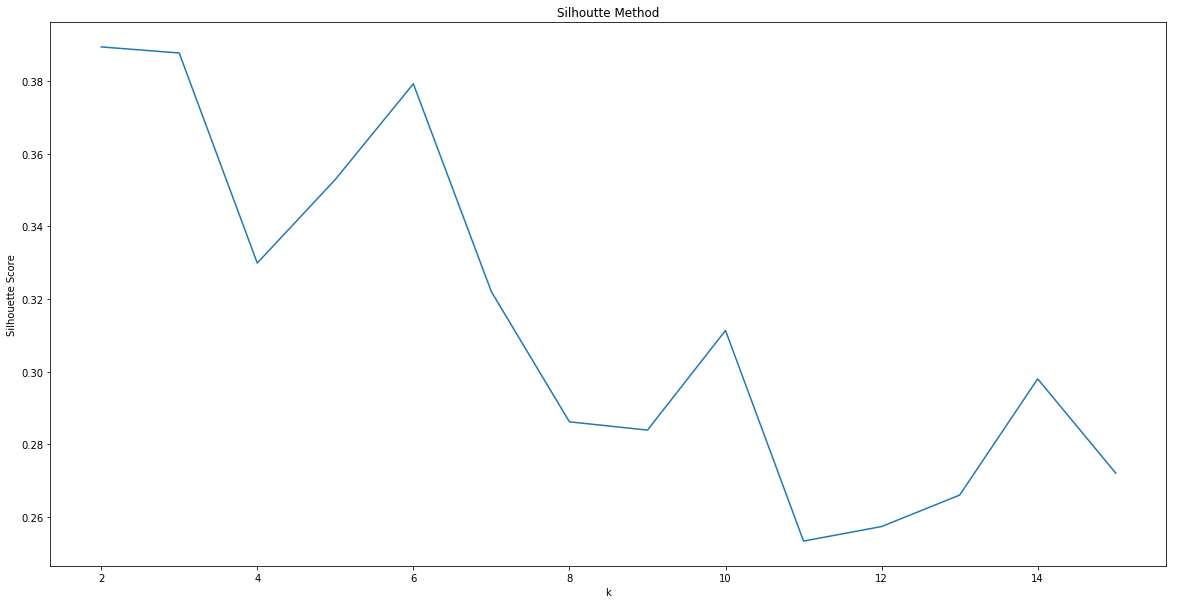

In [313]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Method')
plt.plot(range(2,16), silhouette_score)


For silhouette scores, we are looking for the highest score; here it's at where k=3; 6 is a close second. This suggests that optimal *k=3 or 6*; Let's choose *3*.  Let's remember this for later. For now let's do some PCA.

### Principal Components Analysis

This will help us visualize the clusters.

In [314]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(pca_data, columns=['PCA_1','PCA_2'])
pca_df.shape


(66, 2)

In [315]:
persons_df.dropna(axis=0).shape

(66, 5)

In [316]:
pca_df = persons_df.dropna()[['person','domain']].reset_index().join(pca_df)

In [317]:
pca_df.shape

(66, 5)

In [318]:
persons_cluster.columns

Index(['neg', 'pos', 'comment_length'], dtype='object')

In [319]:
pca_df.tail()

,index,person,domain,PCA_1,PCA_2
61,62,delaney,dems,0.554876,0.953181
62,63,moulton,dems,2.122935,0.154991
63,64,swalwell,dems,1.975774,-0.889898
64,65,williamson,dems,0.552155,2.264896
65,66,yang,dems,1.624982,-0.650858


Let's take a quick digression into plotting our data so far.

In [320]:
px.scatter(data_frame=persons_df.dropna()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='domain'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
           ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Now let's look by PCA.

In [321]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='domain'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

### K-Means Clustering : k=3

In [322]:
# Model with selected k
k_selected = 3

kmeans = KMeans(n_clusters=k_selected, random_state=42)
kmeans.fit(scaled_df)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Add clusters to dataframes.

In [323]:
# Add to pre-PCA DF
persons_cluster['cluster'] = kmeans.labels_.astype(str)

In [324]:
# Add to PCA DF
pca_df['cluster'] = kmeans.labels_.astype(str)

Redo charts, except coded by clusters!

In [325]:
px.scatter(data_frame=persons_cluster.reset_index()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons | By Cluster'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
#            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

In [326]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison, with Similarity Features'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Let's look at clusters in order.

In [327]:
persons_cluster.sort_values(by=['cluster'], axis=0)

,neg,pos,comment_length,cluster
person,,,,
yang,0.127172,0.059265,641.174575,0
tormund,0.126600,0.091105,726.226371,0
margaery,0.142663,0.100301,481.560241,0
ygritte,0.131634,0.102654,500.151220,0
samwell,0.120397,0.086103,591.793651,0
buttigieg,0.121666,0.065769,646.673913,0
warren,0.128463,0.066028,579.511811,0
inslee,0.139332,0.049005,606.786925,0
harris,0.121952,0.073905,601.044709,0


----

# Word Embeddings Analysis <a name='embeddings' />

Let's look at analyzing persons by word embeddings. Perhaps they have interesting relationships within the embedding space!

## Create corpus

In [328]:
# Word2Vec requires that our text have the form of a list
# of 'sentences', where each sentence is itself a list of
# words. How can we put our _Jeopardy!_ clues in that shape?

import string
text = []

for comment in comments['comment']:     
    sentence = comment.translate(str.maketrans('', '', 
                                               string.punctuation)).split(' ')
    
    new_sent = []
    for word in sentence:
        new_sent.append(word.lower().strip().replace('\n',''))
    
    text.append(new_sent)

In [329]:
len(text)

324629

In [330]:
# Constructing the model is simply a matter of
# instantiating a Word2Vec object.

model = gensim.models.Word2Vec(text, sg=1)

In [331]:
# To train, call 'train()'!

model.train(text, total_examples=model.corpus_count, epochs=model.epochs)

(49803783, 66028450)

In [332]:
model.corpus_total_words

13205690

### "Most Similar" Comparisons

In [333]:
# The '.wv' attribute stores the word vectors
model.wv

**A Game of Throne** and **Democratic Presidential candidates** are ostensibly about determining leadership. So let's see if any persons are most similar to the word `leader`?

In [334]:
leader_terms = model.wv.most_similar('leader', topn=10000)

In [335]:
leader_dict = { term[0]: term[1] for term in leader_terms}

In [336]:
len(leader_dict)

10000

In [337]:
leader_dict

{'ruler': 0.7260875701904297,
 'speaker': 0.6567692160606384,
 'uniter': 0.6523469090461731,
 'leadership': 0.6477394104003906,
 'legislator': 0.6226104497909546,
 'leaders': 0.6125959753990173,
 'figurehead': 0.6099358201026917,
 'follower': 0.607729971408844,
 'despot': 0.6030052900314331,
 'sullied': 0.600338339805603,
 'conqueror': 0.5921701192855835,
 'president': 0.5898383855819702,
 'presidentso': 0.5873446464538574,
 'guaido': 0.5844360589981079,
 'dictator': 0.5832207798957825,
 'monarch': 0.5787641406059265,
 'orator': 0.5708832740783691,
 'potus': 0.5694617033004761,
 'storyteller': 0.5688791871070862,
 'negotiator': 0.5664061307907104,
 'conquerer': 0.5659303665161133,
 'superpower': 0.5657888054847717,
 'warrior': 0.5652080774307251,
 'neophyte': 0.5640283823013306,
 'filibusterproof': 0.5638706684112549,
 'dealmaker': 0.560989499092102,
 'diplomat': 0.560684323310852,
 'commander': 0.5604703426361084,
 'protector': 0.557278037071228,
 'swordsman': 0.5551988482475281,
 'po

**Other investigations**

In [338]:
model.wv.most_similar(['dany'], topn=100)

[('daenerys', 0.9310156106948853),
 ('danny', 0.9239912033081055),
 ('danaerys', 0.8603579998016357),
 ('dani', 0.8387976288795471),
 ('jon', 0.8262686729431152),
 ('she', 0.8116717338562012),
 ('daenarys', 0.7954882979393005),
 ('cersei', 0.7873474359512329),
 ('sansa', 0.7703266143798828),
 ('her', 0.769702136516571),
 ('greyworm', 0.742011547088623),
 ('danerys', 0.7365577220916748),
 ('tyrion', 0.7337474822998047),
 ('drogon', 0.7278047800064087),
 ('arya', 0.7264329195022583),
 ('daeny', 0.7213007211685181),
 ('danys', 0.7204446792602539),
 ('that', 0.7169216275215149),
 ('danydany', 0.7151473760604858),
 ('also', 0.7141578197479248),
 ('herthen', 0.714142918586731),
 ('then', 0.7096420526504517),
 ('cercei', 0.7038832902908325),
 ('he', 0.7014856338500977),
 ('herjon', 0.6999151706695557),
 ('everyone', 0.6984027624130249),
 ('him', 0.6948807239532471),
 ('danywe', 0.6939536333084106),
 ('and', 0.6921662092208862),
 ('thatdany', 0.6890550851821899),
 ('varys', 0.6855077743530273)

In [339]:
model.wv.most_similar(['deblasio'], topn=100)

[('blasio', 0.6879367232322693),
 ('swalwell', 0.6673052310943604),
 ('gropey', 0.66526198387146),
 ('bootyjudge', 0.6609246134757996),
 ('weld', 0.6567760705947876),
 ('bidenedit', 0.6563969850540161),
 ('orouke', 0.6509371995925903),
 ('beefington', 0.6483187675476074),
 ('butti', 0.6414922475814819),
 ('moulton', 0.6410166621208191),
 ('delaney', 0.6338632106781006),
 ('kamala', 0.6338061094284058),
 ('bennett', 0.6336656808853149),
 ('bullock', 0.6328898668289185),
 ('berniebut', 0.6321525573730469),
 ('buttgeig', 0.6305561065673828),
 ('vpi', 0.628007173538208),
 ('antimarijuana', 0.6248888373374939),
 ('bidenim', 0.6248183846473694),
 ('gravel', 0.6243836879730225),
 ('whooping', 0.6197389364242554),
 ('bidenyou', 0.6191443800926208),
 ('bredesen', 0.6177945733070374),
 ('hick', 0.6176211833953857),
 ('candidatesif', 0.6173956394195557),
 ('blasio’s', 0.6141066551208496),
 ('sleepy', 0.6133185625076294),
 ('tulsi', 0.6122370958328247),
 ('policyfirst', 0.6103789806365967),
 ('duc

Let's start collecting these similarity scores!

Start with making another copy of `persons_df` so we don't accidentally damage it.

In [340]:
persons_embed_df = persons_df.copy()

In [341]:
persons_embed_df.head()

,person,domain,neg,pos,comment_length
0,bran,got,0.095871,0.096407,831.949230
1,jon,got,0.105712,0.123610,797.009912
2,dany,got,0.101242,0.136775,887.895739
3,davos,got,0.124050,0.092575,692.760499
4,doran,got,0.086200,0.117733,532.200000


Actually, ended up creating a function that add the average similarity score to the person dataframe (where present).

**Using a function to get multiple runs of _most similar_**

Do some prep on inputs to function.

In [342]:
# Create a list of terms for which we want to measure similarity.
smlr_tgt_words = ['leader', 'throne', 'presidential']

topn = 10000 # How many top similarity words we want returned

# Create list of target persons (we may need to ignore some persons)
tgt_persons = [person for person in persons_embed_df['person']]

# Create search term list, based on target person
tgt_person_dict = {}
for person in tgt_persons:
    if person in person_dict.keys():
        tgt_person_dict[person] = person_dict[person]
    
# Create list of all search terms
terms = list(chain(*tgt_person_dict.values()))

# Create nxm person matrix, where n=person m=respective search terms
person_mat = create_person_mat(tgt_persons, person_dict)

persons_embed_df = persons_df.copy()

Add features of similarity scores for these selected terms.

In [343]:
for word in smlr_tgt_words:
    add_similarity_score(tgt_word=word
                        ,topn=topn
                        ,w2v_model=model
                        ,tgt_df=persons_embed_df
                        ,term_vocab=terms
                        ,person_mat=person_mat.T
                        )

Completed for :'leader'
Completed for :'throne'
Completed for :'presidential'


In [344]:
persons_embed_df

,person,domain,neg,pos,comment_length,similarity_leader,similarity_throne,similarity_presidential
0,bran,got,0.095871,0.096407,831.949230,0.000000,0.477542,0.000000
1,jon,got,0.105712,0.123610,797.009912,0.355215,0.604503,0.000000
2,dany,got,0.101242,0.136775,887.895739,0.344843,0.536755,0.000000
3,davos,got,0.124050,0.092575,692.760499,0.335810,0.336705,0.000000
4,doran,got,0.086200,0.117733,532.200000,0.305683,0.382385,0.000000
5,cersei,got,0.104796,0.141244,865.036902,0.000000,0.458362,0.000000
6,tyrion,got,0.108242,0.118347,803.106100,0.364289,0.426687,0.000000
7,sansa,got,0.106343,0.116680,836.954370,0.319934,0.488197,0.000000
8,arya,got,0.098847,0.130279,738.826286,0.000000,0.380832,0.000000
9,stannis,got,0.108586,0.120870,653.408506,0.304734,0.471730,0.000000


**Leader** Top 5

In [345]:
col_slice = ['person','similarity_leader']

persons_embed_df.loc[:,col_slice].sort_values(by=col_slice[::-1]
                                                ,ascending=False).head()

,person,similarity_leader
10,varys,0.398292
61,bennet,0.391132
6,tyrion,0.364289
56,de blasio,0.358813
1,jon,0.355215


**Throne** Top 5

In [346]:
col_slice = ['person','similarity_throne']

persons_embed_df.loc[:, col_slice].sort_values(by=col_slice[::-1]
                                                ,ascending=False).head()

,person,similarity_throne
1,jon,0.604503
27,gendry,0.550039
2,dany,0.536755
34,viserys,0.514963
38,night_king,0.494811


**Presidential** Top 5

In [347]:
col_slice = ['person','similarity_presidential']

persons_embed_df.loc[:, col_slice].sort_values(by=col_slice[::-1]
                                                ,ascending=False).head()

,person,similarity_presidential
57,bullock,0.508574
60,o'rourke,0.492962
52,inslee,0.487627
61,bennet,0.419130
45,biden,0.400576


### Similarity Comparisons

In [348]:
model.wv.similarity('dany', 'warren')

0.39445364

In [349]:
model.wv.similarity('cersei', 'warren')

0.19359715

In [350]:
model.wv.similarity('deblasio', 'warren')

0.5456412

### Vector Math

In [376]:
model.wv.most_similar(positive=['sansa', 'north'], negative='throne')

[('wildlings', 0.24323633313179016),
 ('foreigners', 0.22400444746017456),
 ('communities', 0.22200703620910645),
 ('folk', 0.2139422595500946),
 ('isolated', 0.21216794848442078),
 ('unnecessarily', 0.20413950085639954),
 ('realities', 0.20183444023132324),
 ('westeros', 0.18993139266967773),
 ('downtrodden', 0.1895570605993271),
 ('neighborhoods', 0.18849068880081177)]

In [382]:
model.wv.most_similar(positive=['cersei', 'jamie'], negative='throne')

[('unnecessarily', 0.25146394968032837),
 ('tunnel', 0.23323048651218414),
 ('cercei', 0.22605372965335846),
 ('paths', 0.20367556810379028),
 ('downtrodden', 0.19368955492973328),
 ('neighborhoods', 0.1934000551700592),
 ('bystanders', 0.1926511526107788),
 ('communities', 0.19236493110656738),
 ('jaime', 0.18900012969970703),
 ('straightforward', 0.18652024865150452)]

#### 'doesnt_match()'

In [384]:
model.wv.doesnt_match(['sansa', 'arya', 'jon', 'bran'])

/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'bran'

In [385]:
model.wv.doesnt_match(['trump', 'warren', 'biden', 'harris'])

/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'trump'

In [390]:
model.wv.doesnt_match(['warren', 'biden', 'harris'])

/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'biden'

#### 'closer_than()'

In [387]:
# Which words are closer to 'king' than 'queen' is?

model.wv.closer_than('throne', 'bran')

['he',
 'she',
 'her',
 'him',
 'dany',
 'jon',
 'end',
 'cersei',
 'king',
 'left',
 'power',
 'sansa',
 'north',
 'kings',
 'landing',
 'westeros',
 'daenerys',
 'drogon',
 'rule',
 'claim',
 'iron',
 'herself',
 'snow',
 'kl',
 'nomination',
 'targaryen',
 'kingdoms',
 'ruler',
 'danny',
 'starks',
 'sit',
 'realm',
 'revenge',
 'ruling',
 'wheel',
 'gendry',
 'heir',
 'kingdom',
 'aegon',
 'rightful',
 'crown',
 'hers',
 'viserys',
 'targaryens',
 'baratheon',
 'islands',
 'chair',
 'destiny',
 'dragonstone',
 'danaerys',
 'vengeance',
 'sits',
 'lineage',
 'conquest',
 'targ',
 'birthright',
 'dani',
 'melted',
 'daenarys',
 'lust',
 'quest',
 'heirs',
 'stormlands',
 'bloodline',
 'baratheons',
 'usurper',
 'waits',
 'gendrys',
 'realises',
 'usurped',
 'sidelines',
 'usurp',
 'reclaim',
 'jonaegon',
 'lordship',
 'nightking',
 'abdicate',
 'afterlife',
 'symbolically',
 'danyjon',
 'jondany',
 'storm’s',
 'kls',
 'mantle',
 'presses',
 'battlements',
 'js',
 'commonfolk',
 'mann

#### 'distance()'

In [ ]:
# For this it will make more sense to
# normalize our vectors.

model.init_sims(replace=True)

In [392]:
model.wv.distance('throne', 'jon')

0.3954967260360718

In [393]:
model.wv.distance('throne', 'bran')

0.5224583446979523

In [394]:
model.wv.distance('throne', 'sansa')

0.5118025541305542

In [395]:
model.wv.distance('throne', 'dany')

0.4143723249435425

In [398]:
model.wv.distance('throne', 'tyrion')

0.5701173543930054

### <font color='red'> Note to us: We can probably explore more of these embeddings ideas! </color>

---

## Clusters, revisited <a name='clusters2'/>

In [351]:
persons_embed_df_num = persons_embed_df.drop(['domain'], axis=1).set_index(
                                                                ['person'])

In [352]:
persons_embed_df_num.head()

,neg,pos,comment_length,similarity_leader,similarity_throne,similarity_presidential
person,,,,,,
bran,0.095871,0.096407,831.949230,0.000000,0.477542,0.0
jon,0.105712,0.123610,797.009912,0.355215,0.604503,0.0
dany,0.101242,0.136775,887.895739,0.344843,0.536755,0.0
davos,0.124050,0.092575,692.760499,0.335810,0.336705,0.0
doran,0.086200,0.117733,532.200000,0.305683,0.382385,0.0


In [353]:
ss_2 = StandardScaler()

ss_2.fit(persons_embed_df_num)

scaled_X = ss_2.transform(persons_embed_df_num)

scaled_df_2 = pd.DataFrame(scaled_X
                           ,columns=persons_embed_df_num.columns
                           ,index=persons_embed_df_num.index)

scaled_df_2.head()

,neg,pos,comment_length,similarity_leader,similarity_throne,similarity_presidential
person,,,,,,
bran,-0.916536,-0.149890,0.948253,-0.852655,1.241339,-0.717386
jon,-0.215131,0.776966,0.746595,1.324637,1.882321,-0.717386
dany,-0.533699,1.225546,1.271157,1.261059,1.540285,-0.717386
davos,1.091774,-0.280437,0.144904,1.205692,0.530306,-0.717386
doran,-1.605757,0.576743,-0.781796,1.021026,0.760931,-0.717386


### Find optimal K

**Elbow Method**

In [354]:
# Elbow Method
cluster_variation = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df_2)
    cluster_variation.append(kmeans.inertia_)

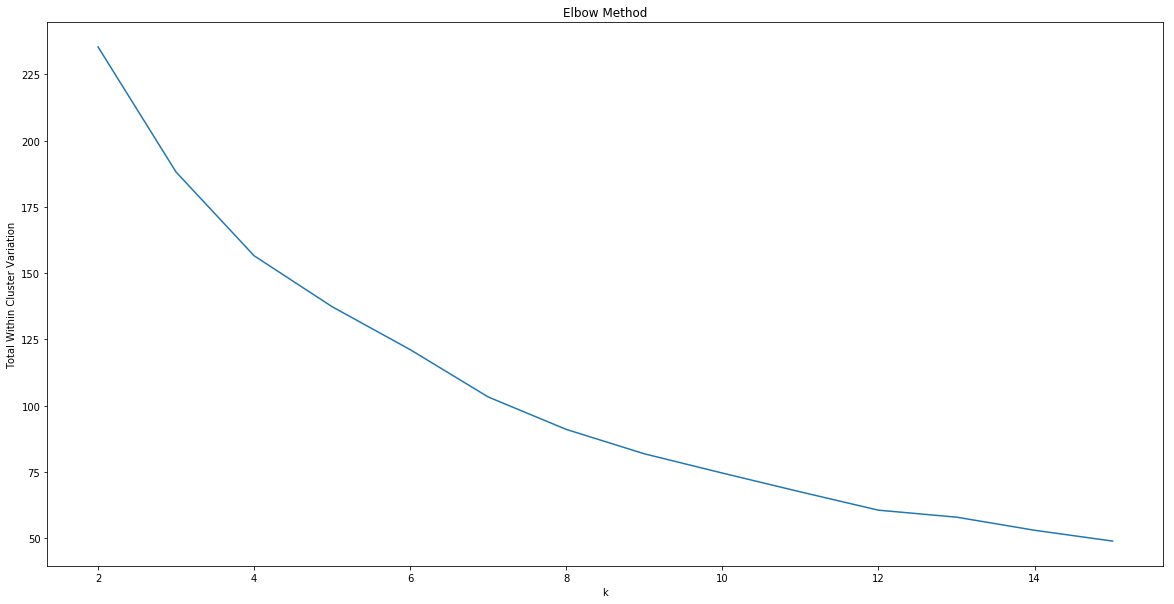

In [355]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Total Within Cluster Variation')
plt.title('Elbow Method')
plt.plot(range(2,16), cluster_variation)


Interesting. Pretty subtle, but maybe 4?

### Silhouette Method

In [356]:
silhouette_score = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_df_2)
    labels = kmeans.labels_
    
    score = metrics.silhouette_score(scaled_df, labels, metric='euclidean')
    silhouette_score.append(score)

In [357]:
#Check 
silhouette_score

[0.30689311781132933,
 0.05891358266878314,
 -0.016940046144792078,
 0.0017686279486915704,
 0.010983733726993542,
 -0.0012032047582616683,
 0.006428812456966109,
 -0.008329248540665302,
 -0.02196776044278684,
 0.005635608481802035,
 -0.037794146630164255,
 -0.05133118960786135,
 -0.05475332829407466,
 -0.04988710255292181]

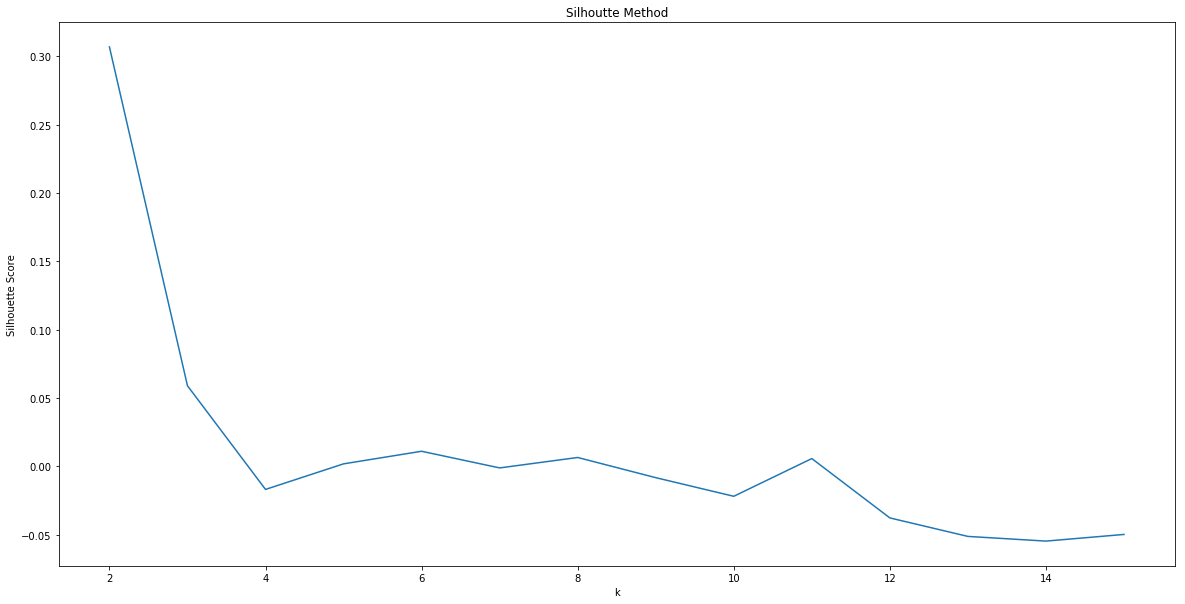

In [358]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Method')
plt.plot(range(2,16), silhouette_score)


Suggests 2 is the best k!

Between the two, 4 would be more interesting to explore.

### Principal Components Analysis - Round 2

This will help us visualize the clusters.

In [400]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(scaled_df_2)

pca_df = pd.DataFrame(pca_data, columns=['PCA_1','PCA_2'])
pca_df.shape


(66, 2)

persons_df.dropna(axis=0).shape

In [412]:
pca_df = persons_df.dropna()[['person','domain']].reset_index().join(pca_df)

In [413]:
pca_df.shape

(66, 6)

In [362]:
pca_df.tail()

,index,person,domain,PCA_1,PCA_2
61,62,delaney,dems,1.386021,1.206130
62,63,moulton,dems,2.868241,-0.768877
63,64,swalwell,dems,2.589414,-0.824214
64,65,williamson,dems,1.953816,-0.304697
65,66,yang,dems,2.205849,1.078377


Now let's look by PCA again, **after adding in new similarity features**.

In [363]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='domain'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison, with Similiarity Features'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Looks like it really sharpened the distincting between the two PCA groupings; you can (almost) draw a straight line between the two PCA groups, whereas before there was some minor overlap.

### K-Means Clustering - k=4

In [406]:
#### Model with selected k
k_selected = 4

kmeans = KMeans(n_clusters=k_selected, random_state=42)
kmeans.fit(scaled_df_2)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Add clusters to dataframes.

In [407]:
# Add to pre-PCA DF
persons_cluster['cluster'] = kmeans.labels_.astype(str)

In [408]:
# Add to PCA DF
pca_df['cluster'] = kmeans.labels_.astype(str)

Redo charts, except coded by clusters!

In [409]:
px.scatter(data_frame=persons_cluster.reset_index()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons | By Cluster'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
#            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Not very compelling.

In [414]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

This is more compelling than just looking at positive vs negative; makes sense because the PCAs have reduced the dimensions down.

Let's look at clusters in order.

In [415]:
persons_cluster.sort_values(by=['cluster'], axis=0)

,neg,pos,comment_length,cluster
person,,,,
bran,0.095871,0.096407,831.949230,0
dragons,0.103937,0.132336,863.264463,0
melisandre,0.099591,0.121415,825.482972,0
bronn,0.111327,0.111018,694.823454,0
gilly,0.110157,0.078380,502.444444,0
ramsey,0.108425,0.147383,629.881952,0
missandei,0.105467,0.144538,891.237405,0
ned,0.106490,0.117499,680.973132,0
catelyn,0.113957,0.111492,698.189189,0


-----

# <font color='steelblue'>Dev and Testing </font>
###  <font color='steelblue'>Delete these eventually </font>

In [ ]:
arr = vectorized_similars.todense()

row_ind_nz = (arr!=0).argmax(axis=0)

In [ ]:
row_ind_nz

So first non-zero row in column 1 is 1701.

In [ ]:
arr[1701,0]

This means that index 1701 of `leader_terms` should give us a character match! 

In [ ]:
leader_terms[1701]

Yes. Seems to work! Let's check another. how about 4073?

In [ ]:
leader_terms[4073]

Let's codify the number $n$ of how many similar words to return from the the `most_similar` method.

In [ ]:
num_similar_words = 10000

Now, let's count vectorize the terms. We'll use the same search term vocabulary as before!

In [ ]:
embed_vectorizer = CountVectorizer(vocabulary=vocab)

In [ ]:
vectorized_similars = embed_vectorizer.transform(
                                    [term[0] for term in leader_terms])

In [ ]:
vectorized_similars.shape

In [ ]:
# Let's spot check. Let's find a non-zero cell.

In [ ]:
arr = vectorized_similars.todense()

row_ind_nz = (arr!=0).argmax(axis=0)

In [ ]:
row_ind_nz

So first non-zero row in column 1 is 1701.

In [ ]:
arr[1701,0]

This means that index 1701 of `leader_terms` should give us a character match! 

In [ ]:
leader_terms[1701]

Yes. Seems to work! Let's check another. how about 4073?

In [ ]:
leader_terms[4073]

Let's codify the number $n$ of how many similar words to return from the the `most_similar` method.

In [ ]:
num_similar_words = 10000

Now, let's count vectorize the terms. We'll use the same search term vocabulary as before!

In [ ]:
embed_vectorizer = CountVectorizer(vocabulary=vocab)

In [ ]:
vectorized_similars = embed_vectorizer.transform(
                                    [term[0] for term in leader_terms])

In [ ]:
vectorized_similars.shape

In [ ]:
# Let's spot check. Let's find a non-zero cell.

In [ ]:
arr = vectorized_similars.todense()

row_ind_nz = (arr!=0).argmax(axis=0)

In [ ]:
row_ind_nz

So first non-zero row in column 1 is 1701.

In [ ]:
arr[1701,0]

This means that index 1701 of `leader_terms` should give us a character match! 

In [ ]:
leader_terms[1701]

Yes. Seems to work! Let's check another. how about 4073?

In [ ]:
leader_terms[4073]

Let's codify the number $n$ of how many similar words to return from the the `most_similar` method.

In [ ]:
num_similar_words = 10000

Now, let's count vectorize the terms. We'll use the same search term vocabulary as before!

In [ ]:
embed_vectorizer = CountVectorizer(vocabulary=vocab)

In [ ]:
vectorized_similars = embed_vectorizer.transform(
                                    [term[0] for term in leader_terms])

In [ ]:
vectorized_similars.shape

In [ ]:
# Let's spot check. Let's find a non-zero cell.

In [ ]:
arr = vectorized_similars.todense()

row_ind_nz = (arr!=0).argmax(axis=0)

In [ ]:
row_ind_nz

So first non-zero row in column 1 is 1701.

In [ ]:
arr[1701,0]

This means that index 1701 of `leader_terms` should give us a character match! 

In [ ]:
leader_terms[1701]

Yes. Seems to work! Let's check another. how about 4073?

In [ ]:
leader_terms[4073]

In [ ]:
# Get leader words
similar_words = [key_val for key_val in leader_dict]

In [ ]:
# Create zeroes matrix
scores_mat = np.zeros((num_similar_words, len(vocab)))

scores_mat.shape

# Loop throught the vocab
for i, search_term in enumerate(vocab):
    col = i
    # If person in similar words list, retrieve the score
    if search_term in similar_words:
#         print(search_term)
        row = similar_words.index(search_term) 
        score = leader_dict[search_term]
        print(row, col, score)
        scores_mat[row, col] = score


Check values.

In [ ]:
# Check
print(vectorized_similars[4073,2])
print(scores_mat[4073,2])

Create a search terms matrix with the scores filled in.

Check size.

In [ ]:
scores_mat.shape

Get scores matched to people.